<a href="https://colab.research.google.com/github/PGestrich/AML-Time-Series-Forecasting/blob/main/AML_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML Project - Time Series Forecasting

Julian Nürk, 

Prisca Gestrich

## Data Stuff

### 1. Utility / Loading Data

In [1]:
#general
import numpy as np
import pandas as pd
!pip install -q kaggle


from google.colab import files

In [2]:
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle competitions download -c 'store-sales-time-series-forecasting'
! mkdir data
! unzip store-sales-time-series-forecasting.zip -d data

Saving kaggle.json to kaggle.json
 23% 5.00M/21.4M [00:00<00:00, 42.7MB/s]
100% 21.4M/21.4M [00:00<00:00, 123MB/s] 
Archive:  store-sales-time-series-forecasting.zip
  inflating: data/holidays_events.csv  
  inflating: data/oil.csv            
  inflating: data/sample_submission.csv  
  inflating: data/stores.csv         
  inflating: data/test.csv           
  inflating: data/train.csv          
  inflating: data/transactions.csv   


In [3]:
oil = pd.read_csv('/content/data/oil.csv')
holidays = pd.read_csv('/content/data/holidays_events.csv')
stores = pd.read_csv('/content/data/stores.csv')
train = pd.read_csv('/content/data/train.csv')
transactions = pd.read_csv('/content/data/transactions.csv')
test = pd.read_csv('/content/data/test.csv')



## Process Data

holiday handling:

0: work day

1 - weekend / bridge day

2 - holiday

type additional: ??? 

transferred holidays are considered normal days

only first holiday in holidays is considered




In [4]:
#change dtype of date column to datetime
oil['date'] = oil['date'].apply(pd.to_datetime)
holidays['date'] = holidays['date'].apply(pd.to_datetime)
train['date']=pd.to_datetime(train ['date'])
#train['date'] = train['date'].apply(pd.to_datetime)
transactions['date'] = transactions['date'].apply(pd.to_datetime)
test['date'] = test['date'].apply(pd.to_datetime)

In [5]:
#expand oil to include all dates + interpolate missing data
oil = oil.set_index('date').asfreq('D').reset_index()
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate('linear').ffill().bfill()
train = train.merge(oil)
train = train.rename(columns={"dcoilwtico": "oilprice"})


#change family names & type to numeric values
encoder_family = LabelEncoder()
train['family_id']=encoder_family.fit_transform(train['family'])



#split up date into multiple informations
train['day'] = train['date'].apply(lambda time: time.day)
train['month'] = train['date'].apply(lambda time: time.month)
train['weekday'] = train['date'].apply(lambda time: time.dayofweek)
train['year'] = train['date'].apply(lambda time: time.year)

#remove noise - 3 months
to_drop = train.loc[train['date'].between('2016-04-16', '2016-07-16')]
train = train.drop(to_drop.index)

prob. faster: do holiday lookup table with clusters instead of store numbers

In [6]:
#holiday handling
def isholiday(row):
  #data
  date = row['date']
  event = holidays.loc[holidays['date'] == date][0:1]
  id = row['store_nbr']
  city = stores.loc[stores['store_nbr'] == id]['city'].values
  state = stores.loc[stores['store_nbr'] == id]['state'].values
  
  
  #check if events apply:
  if len(event) > 0:
    national = event['locale'].values == 'National'
    regional = event['locale'].values == 'Regional' and event['locale_name'].values == state
    local = event['locale'].values == 'Local' and event['locale_name'].values == city
    
    if national[0] or regional[0] or local[0]:
      if event['type'].values == 'Holiday' and  event['transferred'].values == False:
        return 2
      elif event['type'].values == 'Transfer':
        return 2
      elif event['type'].values == 'Bridge':
        return 1
      elif event['type'].values == 'Work Day':
        return 0

  #otherwise: check if weekend
  if row['weekday']< 5:
    return 0
  else: 
    return 1


#lookup table  (adds dates to stores table and gets holiday type)
date1, date2 = train['date'].min(), train['date'].max()
holiday_lookup = stores[['store_nbr', 'type', 'cluster']].copy()
holiday_lookup.loc[:,'holiday'] = 0

holiday_lookup = pd.merge(holiday_lookup, pd.DataFrame({'date': pd.date_range(date1, date2, freq = 'd')}), how = "cross")
holiday_lookup['weekday'] = holiday_lookup['date'].apply(lambda time: time.dayofweek)
holiday_lookup.loc[:, 'holiday'] = holiday_lookup.apply(lambda row: isholiday(row), axis = 1)
holiday_lookup = holiday_lookup.drop('weekday', axis = 1)


#join with train
train = train.merge(holiday_lookup)

encoder_type = LabelEncoder()
train['type']=encoder_type.fit_transform(train['type'])

In [7]:
#create shortened data for test purposes
date1 = '2013-01-01'
date2 = '2013-01-03'

oil_short = oil.loc[oil['date'].between(date1, date2)]
holidays_short = holidays.loc[holidays['date'].between(date1, date2)]
train_short = train.loc[train['date'].between(date1, date2)].copy()
transactions_short = transactions.loc[transactions['date'].between(date1, date2)]

train_short

,id,date,store_nbr,family,sales,onpromotion,oilprice,family_id,day,month,weekday,year,type,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,D,13,2
1,1,2013-01-01,1,BABY CARE,0.000,0,93.14,1,1,1,1,2013,D,13,2
2,2,2013-01-01,1,BEAUTY,0.000,0,93.14,2,1,1,1,2013,D,13,2
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.14,3,1,1,1,2013,D,13,2
4,4,2013-01-01,1,BOOKS,0.000,0,93.14,4,1,1,1,2013,D,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,5341,2013-01-03,9,POULTRY,509.496,0,92.97,28,3,1,3,2013,B,6,0
5342,5342,2013-01-03,9,PREPARED FOODS,66.000,0,92.97,29,3,1,3,2013,B,6,0
5343,5343,2013-01-03,9,PRODUCE,0.000,0,92.97,30,3,1,3,2013,B,6,0
5344,5344,2013-01-03,9,SCHOOL AND OFFICE SUPPLIES,0.000,0,92.97,31,3,1,3,2013,B,6,0


In [8]:
test = pd.read_csv('/content/data/test.csv')
test['date'] = test['date'].apply(pd.to_datetime)

# preprocess test data
test = test.merge(oil)
test = test.rename(columns={"dcoilwtico": "oilprice"})



#change family names & type to numeric values
test['family_id']=encoder_family.fit_transform(test['family'])



#split up date into multiple informations
test['day'] = test['date'].apply(lambda time: time.day)
test['month'] = test['date'].apply(lambda time: time.month)
test['weekday'] = test['date'].apply(lambda time: time.dayofweek)
test['year'] = test['date'].apply(lambda time: time.year)

In [9]:
#test holiday handling

#holiday handling
def isholiday(row):
  #data
  date = row['date']
  event = holidays.loc[holidays['date'] == date][0:1]
  id = row['store_nbr']
  city = stores.loc[stores['store_nbr'] == id]['city'].values
  state = stores.loc[stores['store_nbr'] == id]['state'].values
  
  
  #check if events apply:
  if len(event) > 0:
    national = event['locale'].values == 'National'
    regional = event['locale'].values == 'Regional' and event['locale_name'].values == state
    local = event['locale'].values == 'Local' and event['locale_name'].values == city
    
    if national[0] or regional[0] or local[0]:
      if event['type'].values == 'Holiday' and  event['transferred'].values == False:
        return 2
      elif event['type'].values == 'Transfer':
        return 2
      elif event['type'].values == 'Bridge':
        return 1
      elif event['type'].values == 'Work Day':
        return 0

  #otherwise: check if weekend
  if row['weekday']< 5:
    return 0
  else: 
    return 1


#lookup table  (adds dates to stores table and gets holiday type)
date1, date2 = test['date'].min(), test['date'].max()
holiday_lookup = stores[['store_nbr', 'type', 'cluster']].copy()
holiday_lookup.loc[:,'holiday'] = 0

holiday_lookup = pd.merge(holiday_lookup, pd.DataFrame({'date': pd.date_range(date1, date2, freq = 'd')}), how = "cross")
holiday_lookup['weekday'] = holiday_lookup['date'].apply(lambda time: time.dayofweek)
holiday_lookup.loc[:, 'holiday'] = holiday_lookup.apply(lambda row: isholiday(row), axis = 1)
holiday_lookup = holiday_lookup.drop('weekday', axis = 1)


#join with train
test = test.merge(holiday_lookup)
test['type']=encoder_type.fit_transform(test['type'])

## Test with Shortened Train set

In [ ]:
#create testset only considering automotives at store 1
'''train_auto = train.copy()
print(train_auto.shape[0])
train_auto = train_auto.loc[train_auto['family'] == "AUTOMOTIVE"]
train_auto = train_auto.loc[train_auto['store_nbr'] == 1]
print(train_auto.shape[0])

train_auto['date'] = train_auto['date'].apply(pd.to_datetime)
train_auto['weekday'] = train_auto['date'].apply(lambda time: time.dayofweek)
train_auto['day'] = train_auto['date'].apply(lambda time: time.day)



X_train = train_auto[['id', 'day', 'weekday', 'onpromotion']]
plot_dates = train_auto[['date']]
Y_train = train_auto[['sales']]


train_auto = test.copy()
print(train_auto.shape[0])
train_auto = train_auto.loc[train_auto['family'] == "AUTOMOTIVE"]
train_auto = train_auto.loc[train_auto['store_nbr'] == 1]
print(train_auto.shape[0])

train_auto['date'] = train_auto['date'].apply(pd.to_datetime)
train_auto['weekday'] = train_auto['date'].apply(lambda time: time.dayofweek)
train_auto['day'] = train_auto['date'].apply(lambda time: time.day)

X_test = train_auto[['id', 'day', 'weekday', 'onpromotion']]
'''

'train_auto = train.copy()\nprint(train_auto.shape[0])\ntrain_auto = train_auto.loc[train_auto[\'family\'] == "AUTOMOTIVE"]\ntrain_auto = train_auto.loc[train_auto[\'store_nbr\'] == 1]\nprint(train_auto.shape[0])\n\ntrain_auto[\'date\'] = train_auto[\'date\'].apply(pd.to_datetime)\ntrain_auto[\'weekday\'] = train_auto[\'date\'].apply(lambda time: time.dayofweek)\ntrain_auto[\'day\'] = train_auto[\'date\'].apply(lambda time: time.day)\n\n\n\nX_train = train_auto[[\'id\', \'day\', \'weekday\', \'onpromotion\']]\nplot_dates = train_auto[[\'date\']]\nY_train = train_auto[[\'sales\']]\n\n\ntrain_auto = test.copy()\nprint(train_auto.shape[0])\ntrain_auto = train_auto.loc[train_auto[\'family\'] == "AUTOMOTIVE"]\ntrain_auto = train_auto.loc[train_auto[\'store_nbr\'] == 1]\nprint(train_auto.shape[0])\n\ntrain_auto[\'date\'] = train_auto[\'date\'].apply(pd.to_datetime)\ntrain_auto[\'weekday\'] = train_auto[\'date\'].apply(lambda time: time.dayofweek)\ntrain_auto[\'day\'] = train_auto[\'date\'].a

In [10]:
#create test data for one family

#cluster = stores[['store_nbr', 'cluster']].groupby('cluster').count().idxmax().values[0]
#stores_in_cluster = stores.loc[stores['cluster'] == cluster]['store_nbr'].values

train_simple = train.copy() #train.loc[train['store_nbr'].isin(stores_in_cluster)].copy()
train_simple = train_simple.loc[train_simple['family_id'] == 32]


cols = ['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'type', 'cluster']
sales_simple = train_simple[['sales', 'date']].copy()

X_train = train_simple.loc[train_simple['date'].between('2013-01-01', '2017-07-31')].copy()
X_test = train_simple.loc[train_simple['date'].between('2017-08-01', '2017-08-15')].copy()  
Y_train = sales_simple.loc[sales_simple['date'].between('2013-01-01', '2017-07-31')].copy()
Y_test = sales_simple.loc[sales_simple['date'].between('2017-08-01', '2017-08-15')].copy()

Y_train = Y_train['sales']
Y_test = Y_test['sales']

print(X_train.shape, '\n', Y_train.shape)

(85158, 15) 
 (85158,)


## Regression

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [17]:
#test simple data
cols = ['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'type', 'cluster']

#regr = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=1)
#regr.fit(X_train[cols].values, Y_train.values.ravel())
regr = models[31]
def pred(row):
  X = row[cols].values.reshape(1,-1)
  return regr.predict(X)[0]

predict = X_test[cols].apply(lambda row: pred(row), axis = 1)

print(mean_squared_log_error(Y_test.values, predict, squared=False))


1.70650095308362


## Plots

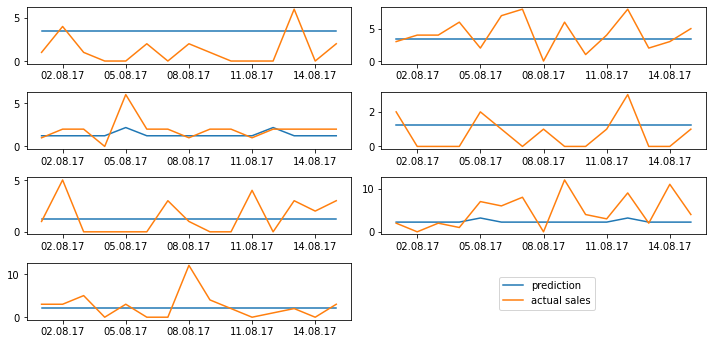

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

#fig, ax = plt.subplots(figsize=(8, 5))

x =  pd.date_range('2017-08-01', '2017-08-15', freq = 'd')
date_form = DateFormatter("%d.%m.%y")
n = len(stores_in_cluster)

#bring values in useful shape
y_val = Y_test.values
y_val = y_val.reshape(-1, n).transpose()
p_val = predict.reshape(-1, n).transpose()


#create subplots
if n % 2 == 0:
      f, axs = plt.subplots(n/2, 2, figsize=(10,5))
else:
    f, axs = plt.subplots(int((n+1)/2), 2,  figsize=(10,5),)

#add values
for i in range(n):
    y1 = p_val[i]
    y2 = y_val[i]

    if i % 2 == 0:
      nb = int(i/2)
    else:
      nb = int((i)/2)
    
    axs[nb, i%2].plot(x, y1)
    axs[nb, i%2].plot(x, y2)
    axs[nb, i%2].xaxis.set_major_formatter(date_form)
    axs[nb, i%2].xaxis.set_major_locator(mdates.DayLocator(interval=3))
        
if n % 2 != 0:
    f.delaxes(axs[int((i)/2), 1])

f.tight_layout() 
f.subplots_adjust(bottom=0.1)   ##  Need to play with this number.
f.legend(labels = ['prediction', 'actual sales'], loc=(.7,.1))

#f.suptitle('Results Random Forest Regression')


f.show()

In [ ]:
'''
fig, ax = plt.subplots(figsize=(20, 8))
#get dates
date1, date2 = sales_simple['date'].min(), sales_simple['date'].max()
plot_dates =  pd.date_range(date1, date2, freq = 'd')

leap = []
for each in plot_dates:
    if each.month==12 and each.day ==25:
        leap.append(each)
plot_dates = plot_dates.drop(leap)

s = sales_simple['sales'].values.reshape(n, -1).transpose()
plt.plot(plot_dates, s, label = stores_in_cluster)
date_form = DateFormatter("%m/%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.title('total sales')
'''

'\nfig, ax = plt.subplots(figsize=(20, 8))\n#get dates\ndate1, date2 = sales_simple[\'date\'].min(), sales_simple[\'date\'].max()\nplot_dates =  pd.date_range(date1, date2, freq = \'d\')\n\nleap = []\nfor each in plot_dates:\n    if each.month==12 and each.day ==25:\n        leap.append(each)\nplot_dates = plot_dates.drop(leap)\n\ns = sales_simple[\'sales\'].values.reshape(n, -1).transpose()\nplt.plot(plot_dates, s, label = stores_in_cluster)\ndate_form = DateFormatter("%m/%y")\nax.xaxis.set_major_formatter(date_form)\nax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))\nplt.title(\'total sales\')\n'

In [ ]:
#plot_dates.difference(sales_simple['date'])


In [ ]:
'''

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

days = np.zeros(7)
counter  = np.zeros(7)

dates = plot_dates.copy()
dates['weekday'] = dates['date'].apply(lambda time: time.dayofweek)

wd = dates['weekday'].values.flatten()

sales = Y_train.values.flatten()
for i in range(len(plot_dates)):
  weekday = wd[i]
  days[weekday] += sales[i]
  counter[weekday] += 1

days = days/counter
fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(days, label = "prediction")
plt.title('average week')
plt.show()

'''

'\n\nimport matplotlib.pyplot as plt\nfrom matplotlib.dates import DateFormatter\nimport matplotlib.dates as mdates\n\ndays = np.zeros(7)\ncounter  = np.zeros(7)\n\ndates = plot_dates.copy()\ndates[\'weekday\'] = dates[\'date\'].apply(lambda time: time.dayofweek)\n\nwd = dates[\'weekday\'].values.flatten()\n\nsales = Y_train.values.flatten()\nfor i in range(len(plot_dates)):\n  weekday = wd[i]\n  days[weekday] += sales[i]\n  counter[weekday] += 1\n\ndays = days/counter\nfig, ax = plt.subplots(figsize=(8, 5))\n#plt.plot(train_short[[\'sales\']], label = "correct value")\nplt.plot(days, label = "prediction")\nplt.title(\'average week\')\nplt.show()\n\n'

In [ ]:

'''import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

days = np.zeros(31)
counter  = np.zeros(31)

dates = plot_dates.copy()
dates['day'] = dates['date'].apply(lambda time: time.day)

wd = dates['day'].values.flatten()

sales = Y_train.values.flatten()
for i in range(len(plot_dates)):
  weekday = wd[i] - 1
  days[weekday] += sales[i]
  counter[weekday] += 1

days = days/counter
fig, ax = plt.subplots(figsize=(8, 5))
#plt.plot(train_short[['sales']], label = "correct value")
plt.plot(range(1, 32), days, label = "prediction")
plt.title('average month')
plt.show()'''

'import matplotlib.pyplot as plt\nfrom matplotlib.dates import DateFormatter\nimport matplotlib.dates as mdates\n\ndays = np.zeros(31)\ncounter  = np.zeros(31)\n\ndates = plot_dates.copy()\ndates[\'day\'] = dates[\'date\'].apply(lambda time: time.day)\n\nwd = dates[\'day\'].values.flatten()\n\nsales = Y_train.values.flatten()\nfor i in range(len(plot_dates)):\n  weekday = wd[i] - 1\n  days[weekday] += sales[i]\n  counter[weekday] += 1\n\ndays = days/counter\nfig, ax = plt.subplots(figsize=(8, 5))\n#plt.plot(train_short[[\'sales\']], label = "correct value")\nplt.plot(range(1, 32), days, label = "prediction")\nplt.title(\'average month\')\nplt.show()'

## Testing Stuff

In [18]:
train

,id,date,store_nbr,family,sales,onpromotion,oilprice,family_id,day,month,weekday,year,type,cluster,holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,0,1,1,1,2013,3,13,2
1,1,2013-01-01,1,BABY CARE,0.000,0,93.14,1,1,1,1,2013,3,13,2
2,2,2013-01-01,1,BEAUTY,0.000,0,93.14,2,1,1,1,2013,3,13,2
3,3,2013-01-01,1,BEVERAGES,0.000,0,93.14,3,1,1,1,2013,3,13,2
4,4,2013-01-01,1,BOOKS,0.000,0,93.14,4,1,1,1,2013,3,13,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836939,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,28,15,8,1,2017,1,6,0
2836940,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,29,15,8,1,2017,1,6,0
2836941,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,30,15,8,1,2017,1,6,0
2836942,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,31,15,8,1,2017,1,6,0


In [12]:
from sklearn.metrics import mean_squared_log_error

In [13]:
#create train&test data
X_train = train.loc[train['date'].between('2013-01-01', '2017-07-31')].copy()
X_test = train.loc[train['date'].between('2017-08-01', '2017-08-15')].copy()
Y_train = train.loc[train['date'].between('2013-01-01', '2017-07-31')]['sales'].copy()
Y_test = train.loc[train['date'].between('2017-08-01', '2017-08-15')]['sales'].copy()

In [ ]:
#full dataset
cols = ['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'type', 'cluster']

regr = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=1)
regr.fit(X_train[cols].values, Y_train.values.ravel())

def pred(row):
  X = row[cols].values.reshape(1,-1)
  return regr.predict(X)[0]

predict = X_test[cols].apply(lambda row: pred(row), axis = 1)

print(mean_squared_log_error(Y_test.values, predict, squared=False))


2.517099256538185


In [69]:
#test with cluster

cluster_nbr = train['cluster'].max()
cols = ['onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'family_id']

X_test['sales'] = 0



for fam in range(1, cluster_nbr):



  idx_train = X_train['cluster']== fam
  regr = RandomForestRegressor(n_estimators = 50, n_jobs=-1, random_state=1)
  X = X_train.loc[idx_train][cols].values
  Y = Y_train.loc[idx_train].values.ravel()
  regr.fit(X, Y)
  idx_test = X_test['cluster']== fam
  pred = regr.predict(X_test[idx_test][cols].values)

  X_test.loc[idx_test,'sales'] = pred
  print('group ', fam, ': ', mean_squared_log_error(Y_test[idx_test].values, pred, squared=False))



print('total: ', mean_squared_log_error(Y_test.values, X_test['sales'].values, squared=False))


group  1 :  0.5864756017311841
group  2 :  0.4538307461696917
group  3 :  0.6214854125107098
group  4 :  0.47563177050737987
group  5 :  0.5340669039886548
group  6 :  0.6037223169948758
group  7 :  0.5462923382373112
group  8 :  0.5145516682587722
group  9 :  0.5307050086776426
group  10 :  0.6302371702306058
group  11 :  0.603951498915369
group  12 :  0.6187089680310737
group  13 :  0.5386603298339061
group  14 :  0.5128118097046985
group  15 :  0.5310510988285886
group  16 :  0.6820227238554394
total:  0.8704504716009682


In [35]:
#test with family

family_nbr = train['family_id'].max()
cols = ['onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'cluster']

X_test['sales'] = 0



for fam in range(family_nbr):



  idx_train = X_train['family_id']== fam
  regr = RandomForestRegressor(n_estimators = 50, n_jobs=-1, random_state=1)
  X = X_train.loc[idx_train][cols].values
  Y = Y_train.loc[idx_train].values.ravel()
  regr.fit(X, Y)
  idx_test = X_test['family_id']== fam
  pred = regr.predict(X_test[idx_test][cols].values)

  X_test.loc[idx_test,'sales'] = pred
  print('group ', fam, ': ', mean_squared_log_error(Y_test[idx_test].values, pred, squared=False))



print('total: ', mean_squared_log_error(Y_test.values, X_test['sales'].values, squared=False))

group  0 :  0.6491556615559356
group  1 :  0.38558852450087533
group  2 :  0.5771325047942113
group  3 :  0.25323590722364175
group  4 :  0.08042289809425002
group  5 :  0.4057670656446254
group  6 :  0.7138994037314627
group  7 :  0.2630666358640922
group  8 :  0.20137944351187456
group  9 :  0.19712519971805254
group  10 :  0.7732257706423776
group  11 :  0.3277714969265676
group  12 :  0.16242395891595296
group  13 :  0.7630322539146459
group  14 :  0.6069239504870354
group  15 :  0.6561697803601798
group  16 :  0.5419417400856319
group  17 :  0.38468145699526923
group  18 :  0.22447566967154786
group  19 :  0.7756810413099974
group  20 :  0.9728020643078045
group  21 :  0.787881580561164
group  22 :  0.5751739683133306
group  23 :  0.6941848785213265
group  24 :  0.8254925969056088
group  25 :  0.22767494684361517
group  26 :  0.6668445022037555
group  27 :  0.6955139438150746
group  28 :  0.7982408254895252
group  29 :  0.7613087855749764
group  30 :  0.151809707883951
group  31 :

In [76]:
#test total 

cols = ['onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'cluster', 'family_id']

X_test['sales'] = 0

  
regr = RandomForestRegressor(n_estimators = 50, n_jobs=-1, random_state=1)
X = X_train.loc[:,cols].values
Y = Y_train.values.ravel()
regr.fit(X, Y)
pred = regr.predict(X_test[cols].values)

X_test.loc[:,'sales'] = pred



print('total: ', mean_squared_log_error(Y_test.values, X_test['sales'].values, squared=False))

total:  0.5686385549148442


In [73]:
#test Ridge
from sklearn.linear_model import Ridge

family_nbr = train['family_id'].max()
cols = ['onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'cluster']

X_test['sales'] = 0



for fam in range(family_nbr):



  idx_train = X_train['family_id']== fam
  clf = Ridge()
  X = X_train.loc[idx_train][cols].values
  Y = Y_train.loc[idx_train].values.ravel()
  clf.fit(X, Y)
  idx_test = X_test['family_id']== fam
  pred = clf.predict(X_test[idx_test][cols].values)

  X_test.loc[idx_test,'sales'] = pred
  print('group ', fam, ': ', mean_squared_log_error(Y_test[idx_test].values, pred, squared=False))



print('total: ', mean_squared_log_error(Y_test.values, X_test['sales'].values, squared=False))

group  0 :  0.6965064617242762
group  1 :  0.3004370746851512
group  2 :  0.7875099291165235
group  3 :  0.5885257351781089
group  4 :  0.14061419953643406
group  5 :  0.7573887522272756
group  6 :  0.7884177342608759
group  7 :  0.5642560880533974
group  8 :  0.7135677407103665
group  9 :  0.5942927608828088
group  10 :  0.8132170681915424
group  11 :  1.04213895750297
group  12 :  0.5234132706550213
group  13 :  1.0613462847897421
group  14 :  0.6444946504159829
group  15 :  0.739501123756726
group  16 :  0.7218827298643932
group  17 :  0.39077581111429605
group  18 :  0.5579079757931933
group  19 :  1.505074151132154
group  20 :  1.4246937061303782
group  21 :  0.9133614171715542
group  22 :  1.1097291176961128
group  23 :  1.0234161240930972
group  24 :  0.7764991229019795
group  25 :  0.6543484166140707
group  26 :  1.022771757020726
group  27 :  0.8658997863575758
group  28 :  0.9122515753941342
group  29 :  0.8806919662683701
group  30 :  0.966090815046814
group  31 :  0.9382414

## Full Dataset

In [ ]:
models = []


family_nbr = train['family_id'].max()

for fam in range(family_nbr):
  train_fam = train.loc[train['family_id']== fam]
  X_train = train_fam[['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month', 'type', 'cluster']].values
  Y_train = train_fam['sales']

  regr = RandomForestRegressor(max_depth=2, random_state=0)
  regr.fit(X_train, Y_train.values.ravel())

  models.append(regr)



In [ ]:
def pred(row):
  i = row['family_id']
  X = row[['store_nbr', 'onpromotion', 'oilprice', 'holiday', 'weekday', 'day', 'month']].values.reshape(1,-1)
  return models[i-1].predict(X)[0]

test['prediction']  = test.apply(lambda row: pred(row), axis = 1)



ValueError: ignored

In [ ]:
path = '/content/submission.csv'
test[['id', 'sales']].to_csv(path, header = 'id,sales', index = False)